<a href="https://colab.research.google.com/github/DevendharanL/FOML/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357287 sha256=1bbca7571b42c18d4882f9673eae71abbbc7f3c0f15d0c49b15cfb2fe82dc1ce
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

In [ ]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
movies_cols = ['movie_id', 'title', 'genres']
users_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']

ratings = pd.read_csv('/content/ratings.dat', sep='::', names=ratings_cols, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('/content/movies.dat', sep='::', names=movies_cols, engine='python', encoding='ISO-8859-1')
users = pd.read_csv('/content/users.dat', sep='::', names=users_cols, engine='python', encoding='ISO-8859-1')


In [ ]:
print(ratings.head())
print(movies.head())
print(users.head())


   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455


In [ ]:
print(f"Number of unique users: {ratings['user_id'].nunique()}")
print(f"Number of unique movies: {ratings['movie_id'].nunique()}")
print(f"Total ratings: {ratings.shape[0]}")


Number of unique users: 6040
Number of unique movies: 3706
Total ratings: 1000209


In [ ]:
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(users.isnull().sum())


user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
movie_id    0
title       0
genres      0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64


Cleaniing

In [ ]:
print(f"Duplicates in ratings: {ratings.duplicated().sum()}")
ratings.drop_duplicates(inplace=True)


Duplicates in ratings: 0


In [ ]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


In [ ]:
genre_dummies = movies['genres'].str.get_dummies('|')
movies = pd.concat([movies, genre_dummies], axis=1)


EDA

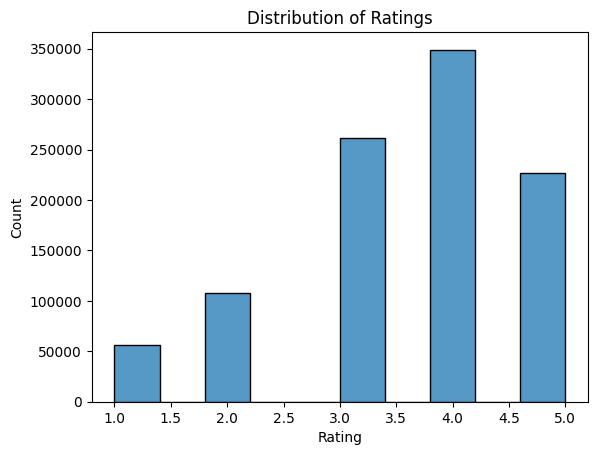

In [ ]:
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


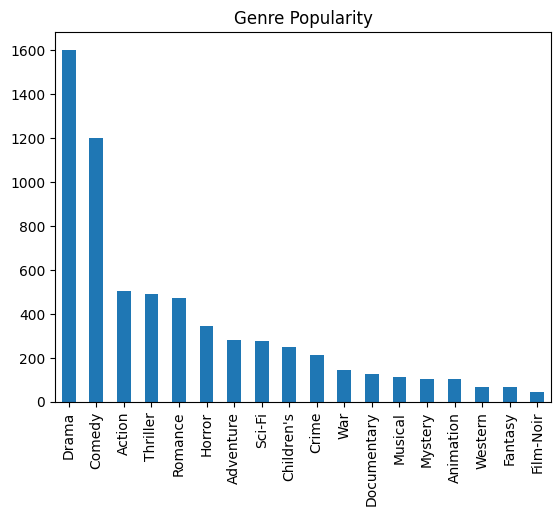

In [ ]:
genre_counts = genre_dummies.sum().sort_values(ascending=False)
genre_counts.plot(kind='bar', title='Genre Popularity')
plt.show()


In [ ]:
most_rated = ratings.groupby('movie_id')['rating'].count().sort_values(ascending=False).head(10)
most_rated_movies = movies[movies['movie_id'].isin(most_rated.index)]
print(most_rated_movies)


      movie_id                                              title  \
257        260          Star Wars: Episode IV - A New Hope (1977)   
476        480                               Jurassic Park (1993)   
585        589                  Terminator 2: Judgment Day (1991)   
589        593                   Silence of the Lambs, The (1991)   
1178      1196  Star Wars: Episode V - The Empire Strikes Back...   
1192      1210  Star Wars: Episode VI - Return of the Jedi (1983)   
1250      1270                          Back to the Future (1985)   
1959      2028                         Saving Private Ryan (1998)   
2502      2571                                 Matrix, The (1999)   
2789      2858                             American Beauty (1999)   

                                   genres  Action  Adventure  Animation  \
257       Action|Adventure|Fantasy|Sci-Fi       1          1          0   
476               Action|Adventure|Sci-Fi       1          1          0   
585            

In [ ]:
avg_ratings = ratings.groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(10)
top_movies = movies[movies['movie_id'].isin(avg_ratings.index)]
print(top_movies)


      movie_id                                      title  \
777        787         Gate of Heavenly Peace, The (1995)   
977        989  Schlafes Bruder (Brother of Sleep) (1995)   
1762      1830                    Follow the Bitch (1998)   
3103      3172                    Ulysses (Ulisse) (1954)   
3164      3233                       Smashing Time (1967)   
3211      3280                           Baby, The (1973)   
3313      3382                     Song of Freedom (1936)   
3538      3607                   One Little Indian (1973)   
3587      3656                               Lured (1947)   
3811      3881                   Bittersweet Motel (2000)   

                    genres  Action  Adventure  Animation  Children's  Comedy  \
777            Documentary       0          0          0           0       0   
977                  Drama       0          0          0           0       0   
1762                Comedy       0          0          0           0       1   
3103    

In [ ]:
user_activity = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)
print(user_activity)


user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
Name: rating, dtype: int64


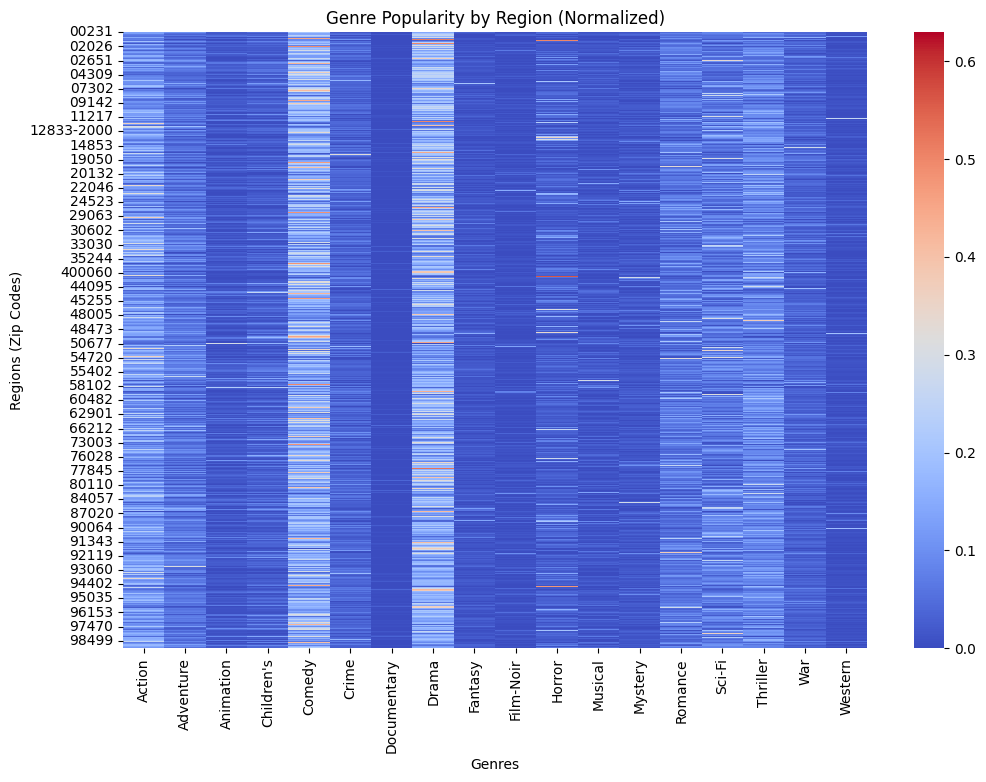

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
users_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
movies_cols = ['movie_id', 'title', 'genres']

ratings = pd.read_csv('/content/ratings.dat', sep='::', names=ratings_cols, engine='python', encoding='ISO-8859-1')
users = pd.read_csv('/content/users.dat', sep='::', names=users_cols, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('/content/movies.dat', sep='::', names=movies_cols, engine='python', encoding='ISO-8859-1')


user_ratings = pd.merge(ratings, users, on='user_id')
merged_data = pd.merge(user_ratings, movies, on='movie_id')


genre_dummies = merged_data['genres'].str.get_dummies('|')
merged_data = pd.concat([merged_data, genre_dummies], axis=1)


region_genre_popularity = merged_data.groupby('zip_code')[genre_dummies.columns].sum()


region_genre_popularity_normalized = region_genre_popularity.div(region_genre_popularity.sum(axis=1), axis=0)


plt.figure(figsize=(12, 8))
sns.heatmap(region_genre_popularity_normalized, cmap='coolwarm', annot=False)
plt.title('Genre Popularity by Region (Normalized)')
plt.xlabel('Genres')
plt.ylabel('Regions (Zip Codes)')
plt.show()



Data integration

In [ ]:
merged_data = pd.merge(ratings, movies, on='movie_id')


In [ ]:
user_item_matrix = merged_data.pivot_table(index='user_id', columns='title', values='rating')
print(user_item_matrix.shape)


(6040, 3706)


BUILDING MODEL

In [ ]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)


svd = SVD()


cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8718  0.8728  0.8753  0.8716  0.8755  0.8734  0.0017  
MAE (testset)     0.6841  0.6854  0.6876  0.6836  0.6880  0.6857  0.0018  
Fit time          18.05   17.36   18.69   17.79   18.61   18.10   0.50    
Test time         2.43    2.94    2.53    2.09    2.12    2.42    0.31    


{'test_rmse': array([0.87179208, 0.87275402, 0.87531885, 0.87161925, 0.87548542]),
 'test_mae': array([0.68410153, 0.68539328, 0.68761358, 0.68363904, 0.68800242]),
 'fit_time': (18.04595422744751,
  17.364381074905396,
  18.68841314315796,
  17.793962717056274,
  18.60957670211792),
 'test_time': (2.4305827617645264,
  2.936704158782959,
  2.5273525714874268,
  2.0918943881988525,
  2.1192545890808105)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)


user_id = 1
movie_id = 10
predicted_rating = svd.predict(user_id, movie_id)
print(predicted_rating)


user: 1          item: 10         r_ui = None   est = 3.68   {'was_impossible': False}
